# Importation des librairies

In [3]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
import scipy as sp
from sklearn.linear_model import LinearRegression
from autosklearn.regression import AutoSklearnRegressor

ModuleNotFoundError: No module named 'autosklearn'

# Chargement des données

In [2]:
archive_train = np.load('C:/Users/Metuarea Herearii/Documents/Owkin/x_train/images/patient_002.npz')
scan = archive_train['scan']
mask = archive_train['mask']

radiomic_train = pd.read_csv('C:/Users/Metuarea Herearii/Documents/Owkin/x_train/features/radiomics.csv')

clinical_train = pd.read_csv('C:/Users/Metuarea Herearii/Documents/Owkin/x_train/features/clinical_data.csv')

# Pré-Traitement

## Images

On importe le nom, le CT scan et le mask dans une liste propre. Ensuite, on crée un dictionnaire avec name en clé et le couple CT scan et mask en valeur.

In [3]:
files = listdir('C:/Users/Metuarea Herearii/Documents/Owkin/x_train/images')

name_train = []
scan_train = []
mask_train = []
for file in files:
    path = 'C:/Users/Metuarea Herearii/Documents/Owkin/x_train/images/'+file
    archive_train = np.load(path)
    name_train.append(file[8:11])
    scan_train.append(archive_train['scan'])
    mask_train.append(archive_train['mask'])
image_train = pd.DataFrame({'PatientID':name_train,'CT scan':scan_train,'mask':mask_train})


## Radiomic

Le tableau Radiomic initial présentait deux premières lignes et colnames incohérent. Nous fusionnons les deux premières lignes pour former une liste qui sera affecter en tant que colnames.

In [4]:
r0=radiomic_train.iloc[[0]].values.tolist()
r1=radiomic_train.iloc[[1]].values.tolist()

r0[0][0]=r1[0][0]


radiomic_train = radiomic_train.set_axis(r0[0],axis=1)

radiomic_train = radiomic_train.drop([0,1])

radiomic_train.head()

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
2,202,0.027815034276150445,0.274891584789629,48.55924216871593,1.5379640537333283,0.650210255286885,5431.333209994288,0.2752277631406584,19786.0,3942944085.0,...,1.4579804820599591,555.3785937091678,14592.30372702833,0.8913295337029291,0.003561530161295479,954.7491354587909,0.00338435209269195,851.9873727726894,0.0044435855454578775,1651.7107610742885
3,371,0.023015490265467994,0.18821000537331142,75.70336848516055,1.744961158341729,0.5730786586392099,10369.568728926952,0.240726823947402,43168.0,3122890068.0,...,2.5121246601768097,1766.6193730958223,22881.93268598017,0.7660321748303586,0.002246203831804831,1092.8237238353574,0.0020694221485567173,884.838627165461,0.0036327469226913886,3386.995589481547
4,246,0.02734810613893409,0.26573989535056836,70.43436661176133,1.5554202430337098,0.6429130676926181,10558.818691399667,0.20076598812381322,52655.0,1059535256.0,...,4.096837887896892,3462.816343789217,18773.106002343673,0.6445541733928403,0.0018803220646738058,878.9896008279054,0.0016345955500716887,634.9100359203011,0.00486911711499068,4232.41808034498
5,240,0.026811108023238883,0.2554063972936345,46.8187996428785,1.5761204705010834,0.634469267239501,4221.412123045331,0.3238779820439811,13074.0,658332446.0,...,1.8243276462412692,683.8697916865876,7978.285175929893,0.8281380543886281,0.00285521581708568,907.0459291041462,0.0026795331834220766,774.8853866820536,0.003900898967927439,1844.746046182932
6,284,0.02369124102797724,0.19942420455106544,53.79591062525106,1.7116200972821958,0.5842417961718578,5295.900331416721,0.3272407286073298,16237.0,807253170.0,...,2.6525799815994477,962.0947604240029,7520.054910032022,0.7348979775536406,0.006709923144392347,1513.4204452600534,0.0047041135494313106,1197.1408999024193,0.023272656916216904,4444.272811805174


## Clinical data

Passage de PatientID de int en str

In [5]:
IDcl = clinical_train['PatientID'].tolist()
for k in range(len(IDcl)):
    identity = str(IDcl[k])
    if len(identity)==1:
        IDcl[k]='00'+identity
    elif len(identity)==2:
        IDcl[k]='0'+identity
    else:
        IDcl[k]=identity

clinical_train['PatientID']=IDcl
clinical_train.head()

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
0,202,Adenocarcinoma,0,0,l2,2,66.0000
1,371,large cell,0,2,l1,4,64.5722
2,246,squamous cell carcinoma,0,3,l1,2,66.0452
3,240,nos,0,2,l1,3,59.3566
4,284,squamous cell carcinoma,0,3,l1,4,71.0554


### Exploration rapide

L'exploration rapide a permis d'effectuer 2 pré-traitement :

1er pré-traitement : conception du dico et correction du tableau radiomic

2e pré-traitement : uniformiser le PatientID en effectuant un changement dans clinical le PatientID de int vers str

Dans clinical, des données manquantes dans Histology et age

Dans radiomic, aucune données manquantes

clinical : 300 x 7

radiomic : 300 x 54

dico : clé 300 ; valeur CT scan & mask

In [6]:
clinical_train.loc[clinical_train['PatientID']=='002']

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
115,002,adenocarcinoma,0,0,l1,3,59.4223


Données manquantes dans clinical

In [7]:
clinical_train.isna().sum()

PatientID         0
Histology        20
Mstage            0
Nstage            0
SourceDataset     0
Tstage            0
age              16
dtype: int64

Sur ces données manquantes, l'Histology n'est pas important pour une prédiction. On décide de le supprimer. L'age pourrait être intéressant en tant qu'indicateur de temps pour un patient. Les valeurs manquantes sont corrrigés en remplacant par la moyenne.

In [8]:
clinical_train['Histology']=clinical_train['Histology'].fillna('inconnu')
clinical_train['Histology']=clinical_train['Histology'].str.lower()
clinical_train['Histology']=clinical_train['Histology'].replace(['nsclc nos (not otherwise specified)'],'nos')
temp=pd.get_dummies(clinical_train['Histology'])
temp.index = clinical_train.index
temp = temp.astype('int64')
temp.dtypes
clinical_train = pd.merge(clinical_train,temp,left_index=True, right_index=True)
clinical_train.pop('Histology')

0               adenocarcinoma
1                   large cell
2      squamous cell carcinoma
3                          nos
4      squamous cell carcinoma
                ...           
295    squamous cell carcinoma
296    squamous cell carcinoma
297                 large cell
298             adenocarcinoma
299                 large cell
Name: Histology, Length: 300, dtype: object

In [9]:
clinical_train.dtypes

PatientID                   object
Mstage                       int64
Nstage                       int64
SourceDataset               object
Tstage                       int64
age                        float64
adenocarcinoma               int64
inconnu                      int64
large cell                   int64
nos                          int64
squamous cell carcinoma      int64
dtype: object

In [10]:
moy = clinical_train['age'].mean(skipna=True)
clinical_train['age']=clinical_train['age'].fillna(moy)

In [11]:
clinical_train.isna().sum()

PatientID                  0
Mstage                     0
Nstage                     0
SourceDataset              0
Tstage                     0
age                        0
adenocarcinoma             0
inconnu                    0
large cell                 0
nos                        0
squamous cell carcinoma    0
dtype: int64

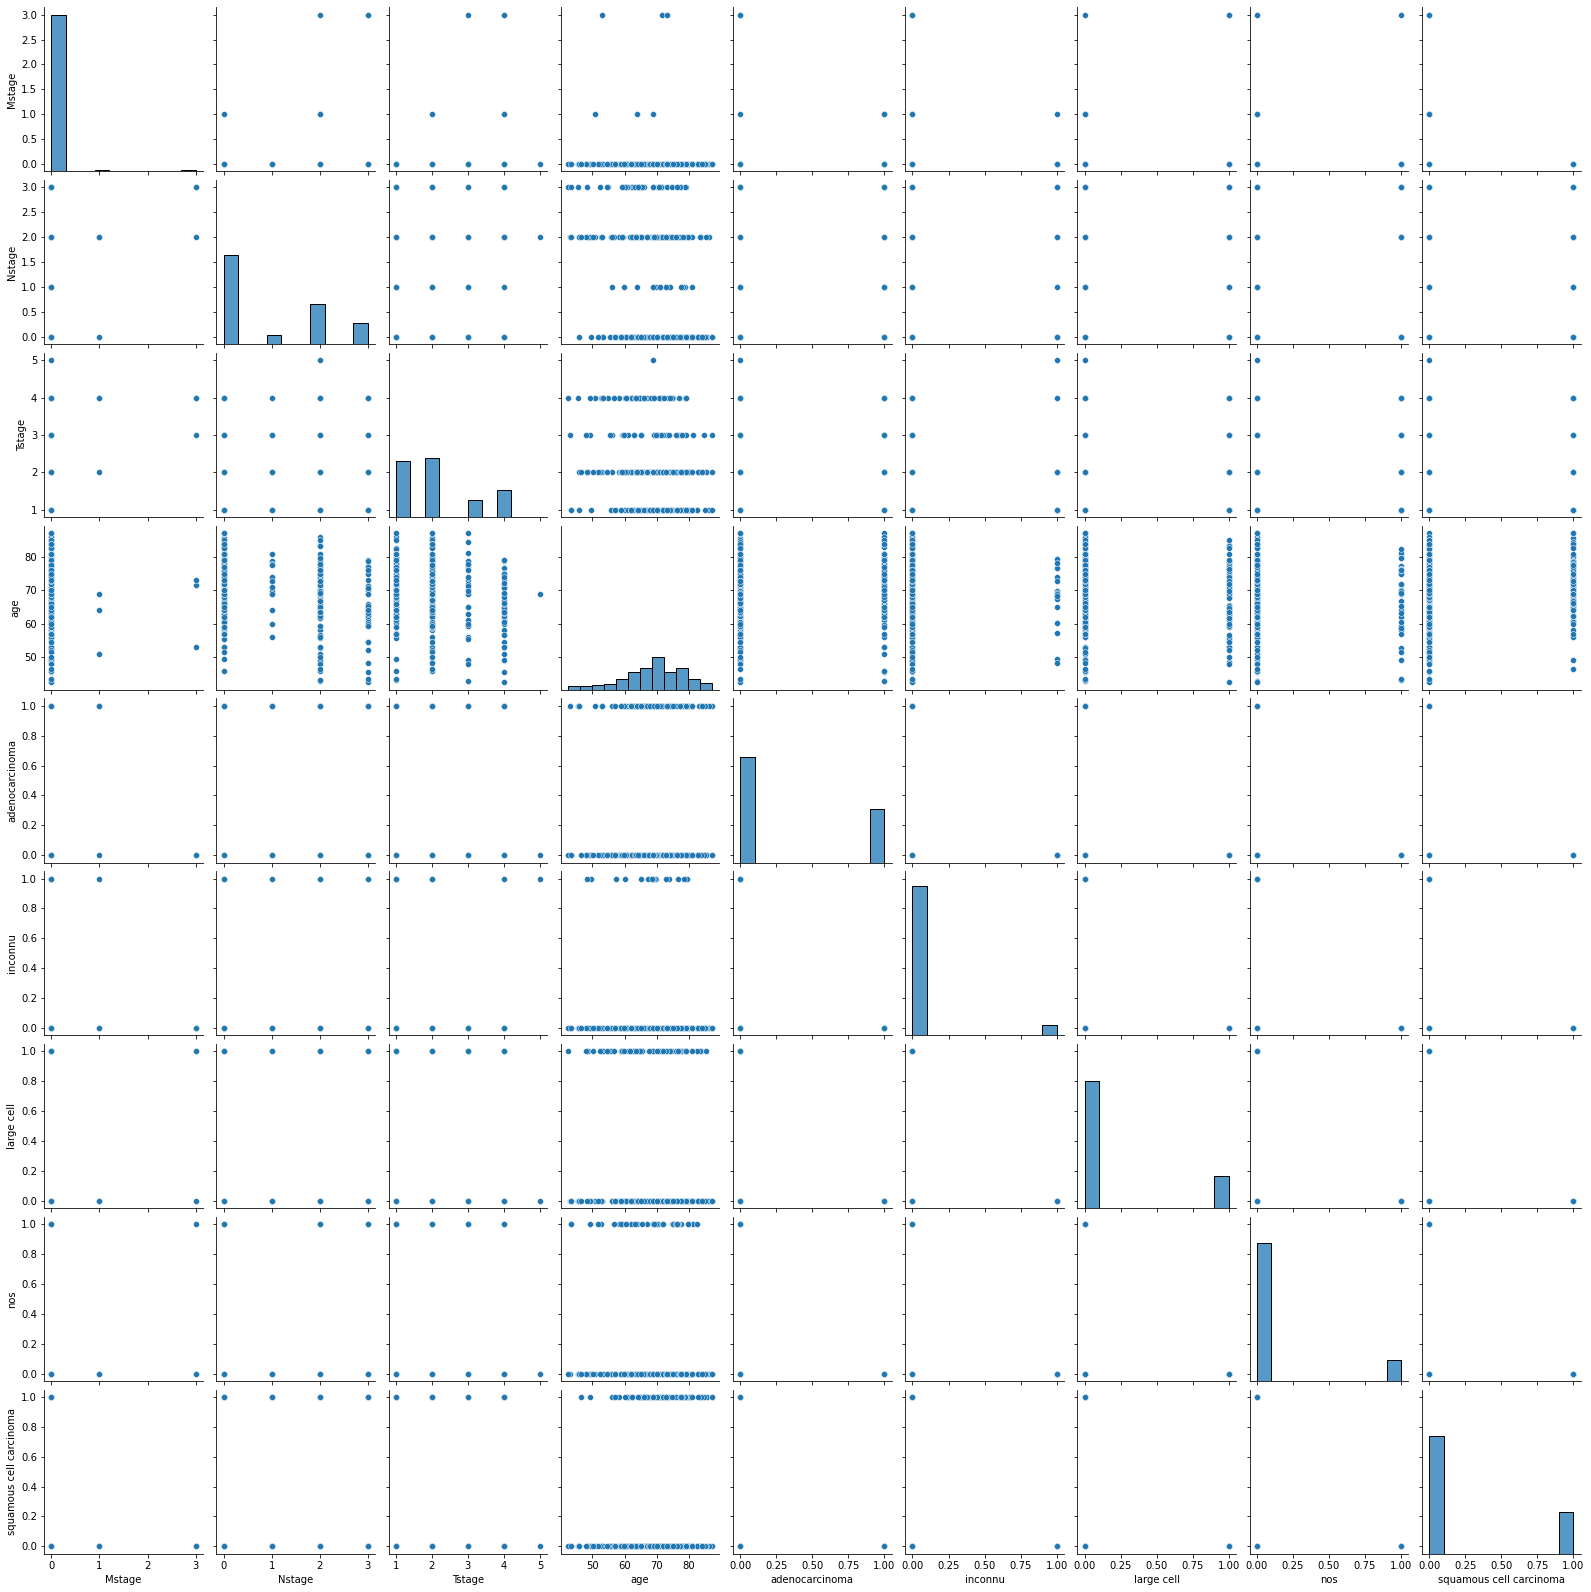

In [12]:
sns.pairplot(clinical_train)

In [13]:
radiomic_train.loc[radiomic_train['PatientID']=='002']

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
117,002,0.02423900376798458,0.20875254484373418,100.68266980965493,1.6857354006588516,0.5932129085081566,26352.06321506184,0.1433847573263521,183911.0,1823931782.0,...,4.681262305294407,20051.58987712051,54352.774028721964,0.6081415634569062,0.000917847073312312,1342.009255967862,0.0007103145045263731,938.1041810710443,0.0035367300592059575,6567.332842370452


Données manquantes dans radiomic

In [14]:
radiomic_train.isna().sum()

PatientID                                       0
original_shape_Compactness1                     0
original_shape_Compactness2                     0
original_shape_Maximum3DDiameter                0
original_shape_SphericalDisproportion           0
original_shape_Sphericity                       0
original_shape_SurfaceArea                      0
original_shape_SurfaceVolumeRatio               0
original_shape_VoxelVolume                      0
original_firstorder_Energy                      0
original_firstorder_Entropy                     0
original_firstorder_Kurtosis                    0
original_firstorder_Maximum                     0
original_firstorder_Mean                        0
original_firstorder_MeanAbsoluteDeviation       0
original_firstorder_Median                      0
original_firstorder_Minimum                     0
original_firstorder_Range                       0
original_firstorder_RootMeanSquared             0
original_firstorder_Skewness                    0


In [15]:
image_train.isna().sum()

PatientID    0
CT scan      0
mask         0
dtype: int64

(array([  0.,  14.,  34., 110., 110.,  32.,   0.]),
 array([ 30,  40,  50,  60,  70,  80,  90, 100]),
 <BarContainer object of 7 artists>)

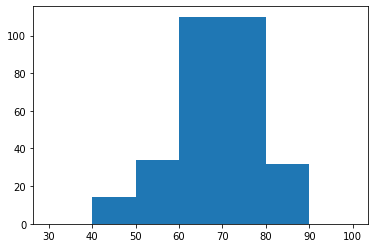

In [16]:
plt.hist(clinical_train['age'],bins=[30,40,50,60,70,80,90,100])

In [17]:
clinical_train.describe()

,Mstage,Nstage,Tstage,age,adenocarcinoma,inconnu,large cell,nos,squamous cell carcinoma
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.040000,0.963333,2.103333,68.766856,0.336667,0.066667,0.203333,0.133333,0.260000
std,0.314212,1.160378,1.072297,9.327554,0.473359,0.249861,0.403151,0.340503,0.439367
min,0.000000,0.000000,1.000000,42.513300,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,63.117525,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,3.000000,75.942475,1.000000,0.000000,0.000000,0.000000,1.000000
max,3.000000,3.000000,5.000000,87.126600,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
sansID = radiomic_train[list(radiomic_train.columns)[1:]]

sansID = sansID.astype(float)

sansID.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.026078,0.255309,63.735090,1.666887,0.618682,10269.274116,0.332531,55941.000000,2.725407e+09,4.232072,...,2.997984,4028.912972,21708.293730,0.770259,0.004949,1053.341229,0.004411,842.425719,0.009939,3956.614366
std,0.006213,0.114462,35.533323,0.321580,0.101082,11020.943961,0.165777,82370.656898,5.094067e+09,0.895564,...,2.277218,7354.203503,30741.811717,0.139863,0.008117,367.251140,0.006535,257.999681,0.025015,3721.271813
min,0.009288,0.030648,13.453624,1.154634,0.312946,409.699505,0.092706,640.000000,2.388461e+07,2.178197,...,1.129743,20.662759,503.361305,0.420690,0.000636,259.345076,0.000401,245.062735,0.001749,325.511805
25%,0.022028,0.172413,33.915016,1.443163,0.556575,2187.199167,0.200968,5586.750000,5.434917e+08,3.539630,...,1.380404,179.737494,3594.097996,0.653939,0.001541,790.854216,0.001333,657.397218,0.003539,1396.425566
50%,0.026071,0.241503,57.823002,1.605803,0.622741,5669.467145,0.296289,19523.000000,1.093244e+09,4.372496,...,2.183706,891.648859,10812.628268,0.793196,0.002709,1048.240239,0.002490,850.097187,0.004787,2566.288530
75%,0.030600,0.332701,82.933158,1.796703,0.692923,14084.942660,0.426285,68332.250000,2.994063e+09,5.017558,...,3.928845,4138.067422,28318.086695,0.903259,0.005065,1323.465451,0.004650,1017.454004,0.007573,5583.538887
max,0.042759,0.649631,216.716405,3.195442,0.866075,67799.783468,0.828710,502660.000000,5.101016e+10,5.585623,...,19.569205,61727.567864,267812.272378,0.960043,0.095065,1960.134253,0.069937,1621.293515,0.282310,25570.594397


# Pré-traitement échantillon test

In [19]:
files = listdir('C:/Users/Metuarea Herearii/Documents/Owkin/x_test/images')

name_test = []
scan_test = []
mask_test = []
for file in files:
    path = 'C:/Users/Metuarea Herearii/Documents/Owkin/x_test/images/'+file
    archive_test = np.load(path)
    name_test.append(file[8:11])
    scan_test.append(archive_test['scan'])
    mask_test.append(archive_test['mask'])
image_test = pd.DataFrame({'PatientID':name_test,'CT scan':scan_test,'mask':mask_test})

In [20]:
radiomic_test = pd.read_csv('C:/Users/Metuarea Herearii/Documents/Owkin/x_test/features/radiomics.csv')

clinical_test = pd.read_csv('C:/Users/Metuarea Herearii/Documents/Owkin/x_test/features/clinical_data.csv')

In [21]:
IDcl = clinical_test['PatientID'].tolist()
for k in range(len(IDcl)):
    identity = str(IDcl[k])
    if len(identity)==1:
        IDcl[k]='00'+identity
    elif len(identity)==2:
        IDcl[k]='0'+identity
    else:
        IDcl[k]=identity

clinical_test['PatientID']=IDcl
clinical_test.head()

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
0,013,nos,0,0,l1,4,44.3970
1,155,adenocarcinoma,0,3,l1,1,63.3183
2,404,large cell,0,2,l1,2,64.7255
3,407,nos,0,0,l1,2,65.3635
4,009,Adenocarcinoma,0,0,l2,2,50.0000


In [22]:
clinical_test.isna().sum()

PatientID         0
Histology        12
Mstage            0
Nstage            0
SourceDataset     0
Tstage            0
age               4
dtype: int64

In [23]:
clinical_test['Histology']=clinical_test['Histology'].fillna('inconnu')
clinical_test['Histology']=clinical_test['Histology'].str.lower()
clinical_test['Histology']=clinical_test['Histology'].replace(['nsclc nos (not otherwise specified)'],'nos')
temp=pd.get_dummies(clinical_test['Histology'])
temp.index = clinical_test.index
temp = temp.astype('int64')
clinical_test = pd.merge(clinical_test,temp,left_index=True, right_index=True)
clinical_test.pop('Histology')
moy = clinical_test['age'].mean(skipna=True)
clinical_test['age']=clinical_test['age'].fillna(moy)

In [24]:
radiomic_test.isna().sum()

Unnamed: 0       1
shape            1
shape.1          1
shape.2          1
shape.3          1
shape.4          1
shape.5          1
shape.6          1
shape.7          1
firstorder       1
firstorder.1     1
firstorder.2     1
firstorder.3     1
firstorder.4     1
firstorder.5     1
firstorder.6     1
firstorder.7     1
firstorder.8     1
firstorder.9     1
firstorder.10    1
firstorder.11    1
firstorder.12    1
firstorder.13    1
textural         1
textural.1       1
textural.2       1
textural.3       1
textural.4       1
textural.5       1
textural.6       1
textural.7       1
textural.8       1
textural.9       1
textural.10      1
textural.11      1
textural.12      1
textural.13      1
textural.14      1
textural.15      1
textural.16      1
textural.17      1
textural.18      1
textural.19      1
textural.20      1
textural.21      1
textural.22      1
textural.23      1
textural.24      1
textural.25      1
textural.26      1
textural.27      1
textural.28      1
textural.29 

In [25]:
r0=radiomic_test.iloc[[0]].values.tolist()
r1=radiomic_test.iloc[[1]].values.tolist()

r0[0][0]=r1[0][0]


radiomic_test = radiomic_test.set_axis(r0[0],axis=1)

radiomic_test = radiomic_test.drop([0,1])

radiomic_test.head()

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
2,013,0.02888521807913762,0.2964514286695039,106.90182411914213,1.4997383054588147,0.6667829956467439,29085.541425363514,0.11452777845917761,254069.0,2006942430.0,...,5.786838511970755,21219.447221119444,64776.69757926393,0.5670945839364655,0.0014934974903616607,808.353957091605,0.0010936026706116241,554.1119978588921,0.007534740404869377,4654.031975617358
3,155,0.03194837238720588,0.36266005403772866,18.81488772222678,1.402275757481352,0.7131264978837789,629.44364000626,0.7038788258387029,911.0,262393816.0,...,1.1603967538271833,25.291607680973797,795.6752799214078,0.9534746263615637,0.011646089610174305,548.9645727442402,0.010835520680564275,529.6440291417058,0.01563269704193925,639.6219629172265
4,404,0.015998834925719053,0.0909450279994979,105.08092119885512,2.223687115406422,0.4497035545476147,12509.265443769824,0.3152976995595148,39809.0,665032231.0,...,4.064385250880343,3225.8083324725712,14007.50928452286,0.6442474353499499,0.0011709310388930345,1600.9522654535785,0.001003034008071181,1181.3777735448612,0.003026516852404476,7156.937666524343
5,407,0.031357660885439724,0.3493731813120354,46.968074263269514,1.419831515538599,0.7043089190907696,4067.6573722770927,0.28210398587121804,14458.0,375428731.0,...,2.902585983552506,1147.928169625991,6094.8055835410405,0.7114666354533556,0.0021042753512783884,1533.2177880035028,0.0018997254630333837,1182.8763633701415,0.003685003163801367,4776.549407884615
6,009,0.017814538285697575,0.1127590447058208,56.542019772908716,2.069900823752435,0.4831149340706782,7093.365689658921,0.37603157853867447,18942.0,9108915274.0,...,1.195504779594246,652.0713671481254,15924.101510304838,0.942025454220576,0.01928124971242974,344.20578608557054,0.01822101655661966,331.90121216251634,0.024175162483351866,400.01584748374046


In [26]:
image_test.isna().sum()

PatientID    0
CT scan      0
mask         0
dtype: int64

# Traitement

Nous avons trois jeux de données : images, radiomic, clinical.
    
Pour concevoir un modèle de prédiction :
    
    - image_test / image_train : CNN
    - radiomic_test / radiomic_train et clinical_test / clinical_train : reduction, regression
        
Effectuer CNN sur les images prendra du temps compte tenu des délais imparti.

Il est possible de réfléchir à un stratégie utilisant reduction et regression pour obtenir un résultat en quelques semaines.

Nous utiliserons les données radiomic et clinical dans la suite.

In [27]:
print(image_test.shape,image_train.shape)
print(radiomic_test.shape,radiomic_train.shape)
print(clinical_test.shape,clinical_train.shape)

(125, 3) (300, 3)
(125, 54) (300, 54)
(125, 11) (300, 11)


In [28]:
clinical_test.head()

,PatientID,Mstage,Nstage,SourceDataset,Tstage,age,adenocarcinoma,inconnu,large cell,nos,squamous cell carcinoma
0,013,0,0,l1,4,44.3970,0,0,0,1,0
1,155,0,3,l1,1,63.3183,1,0,0,0,0
2,404,0,2,l1,2,64.7255,0,0,1,0,0
3,407,0,0,l1,2,65.3635,0,0,0,1,0
4,009,0,0,l2,2,50.0000,1,0,0,0,0


<BarContainer object of 2 artists>

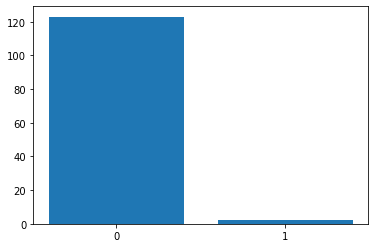

In [29]:
temp=Counter(clinical_test['Mstage'])
x=list(temp.keys())
y=list(temp.values())
plt.bar(range(len(temp)),y,tick_label=x)

<BarContainer object of 5 artists>

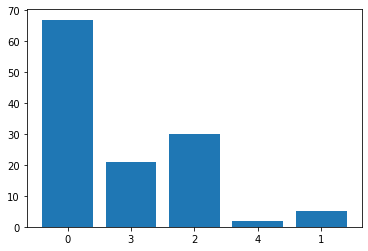

In [30]:
temp=Counter(clinical_test['Nstage'])
x=list(temp.keys())
y=list(temp.values())
plt.bar(range(len(temp)),y,tick_label=x)

<BarContainer object of 5 artists>

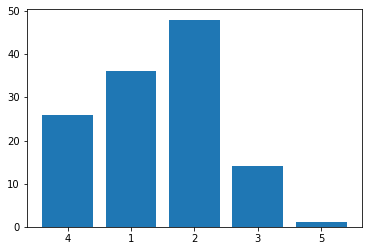

In [31]:
temp=Counter(clinical_test['Tstage'])
x=list(temp.keys())
y=list(temp.values())
plt.bar(range(len(temp)),y,tick_label=x)

## data_train et data_test

In [32]:
radiomic_train
radiomic_train.index=radiomic_train['PatientID']
radiomic_train.pop('PatientID')
radiomic_train

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
202,0.027815034276150445,0.274891584789629,48.55924216871593,1.5379640537333283,0.650210255286885,5431.333209994288,0.2752277631406584,19786.0,3942944085.0,5.138062382118321,...,1.4579804820599591,555.3785937091678,14592.30372702833,0.8913295337029291,0.003561530161295479,954.7491354587909,0.00338435209269195,851.9873727726894,0.0044435855454578775,1651.7107610742885
371,0.023015490265467994,0.18821000537331142,75.70336848516055,1.744961158341729,0.5730786586392099,10369.568728926952,0.240726823947402,43168.0,3122890068.0,4.461053722332744,...,2.5121246601768097,1766.6193730958223,22881.93268598017,0.7660321748303586,0.002246203831804831,1092.8237238353574,0.0020694221485567173,884.838627165461,0.0036327469226913886,3386.995589481547
246,0.02734810613893409,0.26573989535056836,70.43436661176133,1.5554202430337098,0.6429130676926181,10558.818691399667,0.20076598812381322,52655.0,1059535256.0,3.437110589654181,...,4.096837887896892,3462.816343789217,18773.106002343673,0.6445541733928403,0.0018803220646738058,878.9896008279054,0.0016345955500716887,634.9100359203011,0.00486911711499068,4232.41808034498
240,0.026811108023238883,0.2554063972936345,46.8187996428785,1.5761204705010834,0.634469267239501,4221.412123045331,0.3238779820439811,13074.0,658332446.0,4.3525641618756525,...,1.8243276462412692,683.8697916865876,7978.285175929893,0.8281380543886281,0.00285521581708568,907.0459291041462,0.0026795331834220766,774.8853866820536,0.003900898967927439,1844.746046182932
284,0.02369124102797724,0.19942420455106544,53.79591062525106,1.7116200972821958,0.5842417961718578,5295.900331416721,0.3272407286073298,16237.0,807253170.0,4.055700408847022,...,2.6525799815994477,962.0947604240029,7520.054910032022,0.7348979775536406,0.006709923144392347,1513.4204452600534,0.0047041135494313106,1197.1408999024193,0.023272656916216904,4444.272811805174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,0.03575188711388587,0.45415090808431535,36.61966684720111,1.3009679701731398,0.7686584319727061,3143.9726790843724,0.2814405764107396,11204.0,1299545944.0,4.747964393386922,...,2.1267453161798318,336.5736217607421,6761.904880588389,0.8071567846648176,0.0030263471540989176,791.2955059720019,0.002828847859846127,659.1032797198598,0.0044000796957435195,2243.6893178491055
298,0.011765215791089918,0.049181530602555854,122.53162856993292,2.7293924539047882,0.366381902525361,20785.949532147188,0.33261377571233763,62744.0,395285569.0,2.7161802055689606,...,4.405808671502962,7158.438787435351,18591.140070820802,0.6133359978030384,0.0010222643954205016,1592.1900508318274,0.0008124873030212564,1123.462319898394,0.003265340148316901,7145.459719145346
129,0.02566821368023103,0.23409575485173154,64.87680633323437,1.6225651878273755,0.6163080580688447,9571.675019754168,0.224665013016222,42663.0,122782699.0,2.368996645158086,...,7.254938625898857,4513.100699296329,8467.466888384817,0.511172534658928,0.001134970199763957,1030.1979529954301,0.0007836233063791739,637.7185435233446,0.00698335929515609,7752.5995085659315


In [33]:
radiomic_test.index=radiomic_test['PatientID']
radiomic_test.pop('PatientID')

PatientID
013    013
155    155
404    404
407    407
009    009
      ... 
066    066
132    132
169    169
199    199
274    274
Name: PatientID, Length: 125, dtype: object

In [34]:
radiomic_test = radiomic_test.astype('float')
radiomic_train = radiomic_train.astype('float')

In [35]:
clinical_train.index=clinical_train['PatientID']
clinical_train.pop('PatientID')

PatientID
202    202
371    371
246    246
240    240
284    284
      ... 
261    261
298    298
129    129
273    273
366    366
Name: PatientID, Length: 300, dtype: object

In [36]:
clinical_test.index=clinical_test['PatientID']
clinical_test.pop('PatientID')

PatientID
013    013
155    155
404    404
407    407
009    009
      ... 
066    066
132    132
169    169
199    199
274    274
Name: PatientID, Length: 125, dtype: object

In [37]:
image_test.index=image_test['PatientID']
image_test.pop('PatientID')

PatientID
000    000
001    001
006    006
009    009
010    010
      ... 
411    411
412    412
413    413
415    415
419    419
Name: PatientID, Length: 125, dtype: object

In [38]:
image_train.index=image_train['PatientID']
image_train.pop('PatientID')

PatientID
002    002
003    003
004    004
005    005
007    007
      ... 
420    420
421    421
422    422
423    423
424    424
Name: PatientID, Length: 300, dtype: object

In [39]:
x_train = pd.merge(radiomic_train,clinical_train,left_index=True, right_index=True)
x_test = pd.merge(radiomic_test,clinical_test,left_index=True, right_index=True)

In [40]:
y_train = pd.read_csv('C:/Users/Metuarea Herearii/Documents/Owkin/y_train.csv')
y_train.index = y_train['PatientID']
y_train.pop('PatientID')

PatientID
202    202
371    371
246    246
240    240
284    284
      ... 
261    261
298    298
129    129
273    273
366    366
Name: PatientID, Length: 300, dtype: int64

<BarContainer object of 2 artists>

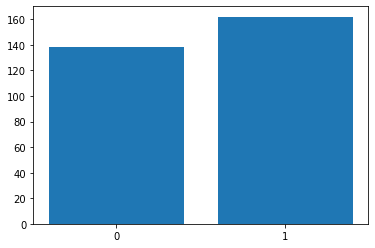

In [41]:
temp=Counter(y_train['Event'])
x=list(temp.keys())
y=list(temp.values())
plt.bar(range(len(temp)),y,tick_label=x)

Deux plots décès vivant

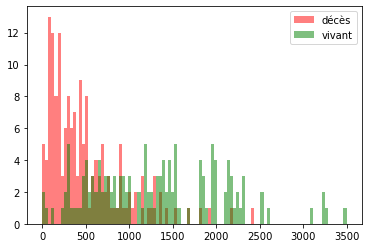

In [42]:
bins = np.linspace(0,3500,100)
no = y_train[y_train['Event']==1]
plt.hist(no['SurvivalTime'],bins,alpha=0.5,color='red',label='décès')
yes = y_train[y_train['Event']==0]
plt.hist(yes['SurvivalTime'],bins,alpha=0.5,color='green',label='vivant')
plt.legend(loc='upper right')

In [43]:
x_train.pop('SourceDataset')

PatientID
202    l2
371    l1
246    l1
240    l1
284    l1
       ..
261    l1
298    l1
129    l1
273    l2
366    l1
Name: SourceDataset, Length: 300, dtype: object

In [44]:
x_test.pop('SourceDataset')

PatientID
013    l1
155    l1
404    l1
407    l1
009    l2
       ..
066    l1
132    l1
169    l2
199    l1
274    l1
Name: SourceDataset, Length: 125, dtype: object

Nous avons x_train (radiomic train et clinical train) et x_test (radiomic test et clinical test) 

Nous avons y_train (Event et Survival time). On cherche y_test.

In [45]:
print(x_train.shape,y_train.shape)

(300, 62) (300, 2)


In [46]:
image_test['CT scan'].isna().sum()

0

## Regression

In [77]:
abs(x_train.corr())

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunHighGrayLevelEmphasis,Mstage,Nstage,Tstage,age,adenocarcinoma,inconnu,large cell,nos,squamous cell carcinoma
original_shape_Compactness1,1.000000,0.987308,0.599702,0.948558,0.998254,0.470682,0.109483,0.275705,0.308995,0.048711,...,0.145251,0.097380,0.165180,0.279616,0.003881,0.081462,0.205318,0.033469,0.034763,0.086647
original_shape_Compactness2,0.987308,1.000000,0.585243,0.889150,0.976333,0.454522,0.131440,0.281400,0.291532,0.068540,...,0.158256,0.085883,0.167137,0.293260,0.006978,0.076321,0.219484,0.026519,0.029608,0.089870
original_shape_Maximum3DDiameter,0.599702,0.585243,1.000000,0.585455,0.601481,0.873098,0.631682,0.778222,0.414728,0.517604,...,0.585460,0.078912,0.272775,0.429538,0.031275,0.212831,0.094199,0.070160,0.068427,0.165460
original_shape_SphericalDisproportion,0.948558,0.889150,0.585455,1.000000,0.965305,0.471096,0.063907,0.245547,0.320227,0.015775,...,0.112210,0.125695,0.152019,0.228249,0.001558,0.083014,0.166488,0.051530,0.035851,0.080309
original_shape_Sphericity,0.998254,0.976333,0.601481,0.965305,1.000000,0.474059,0.101139,0.271923,0.313629,0.041821,...,0.139741,0.102197,0.163700,0.272155,0.003111,0.082728,0.199049,0.036626,0.035808,0.085424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adenocarcinoma,0.081462,0.076321,0.212831,0.083014,0.082728,0.169997,0.264249,0.165598,0.005048,0.366276,...,0.333157,0.045872,0.208829,0.240083,0.027813,1.000000,0.190401,0.359915,0.279433,0.422284
inconnu,0.205318,0.219484,0.094199,0.166488,0.199049,0.111267,0.011213,0.096456,0.105610,0.018159,...,0.030279,0.008520,0.095359,0.138144,0.038062,0.190401,1.000000,0.135021,0.104828,0.158419
large cell,0.033469,0.026519,0.070160,0.051530,0.036626,0.053599,0.159393,0.050548,0.051778,0.207064,...,0.128262,0.093992,0.344857,0.191066,0.119311,0.359915,0.135021,1.000000,0.198157,0.299459
nos,0.034763,0.029608,0.068427,0.035851,0.035808,0.082039,0.069245,0.090854,0.055505,0.150281,...,0.153074,0.043764,0.097061,0.072058,0.046995,0.279433,0.104828,0.198157,1.000000,0.232495


<AxesSubplot:>

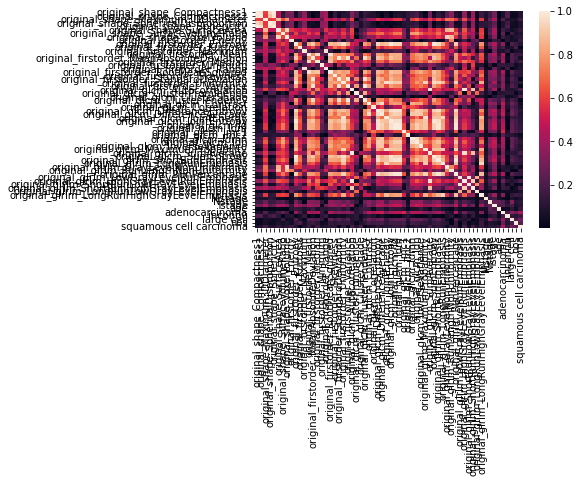

In [72]:
correlation = x_train.corr()
sns.heatmap(abs(correlation), 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns)

On supprime les variables ayant une forte colinéarité. Celles-ci entraine du bruit dans le modèle (Problème de multicolinéarité)

In [73]:
x_train.columns

Index(['original_shape_Compactness1', 'original_shape_Compactness2',
       'original_shape_Maximum3DDiameter',
       'original_shape_SphericalDisproportion', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_Kurtosis',
       'original_firstorder_Maximum', 'original_firstorder_Mean',
       'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range', 'original_firstorder_RootMeanSquared',
       'original_firstorder_Skewness', 'original_firstorder_StandardDeviation',
       'original_firstorder_Uniformity', 'original_firstorder_Variance',
       'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence',
       'original_glcm_ClusterShade', 'original_glcm_ClusterTendency',
       'original_glcm_Contrast', 'origina

In [114]:
temp=[ 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_Kurtosis',
       'original_firstorder_Maximum', 'original_firstorder_Mean',
       'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range', 'original_firstorder_RootMeanSquared',
       'original_firstorder_Skewness', 'original_firstorder_StandardDeviation',
       'original_firstorder_Uniformity', 'original_firstorder_Variance',
       'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence',
       'original_glcm_ClusterShade', 'original_glcm_ClusterTendency',
       'original_glcm_Contrast', 'original_glcm_Correlation',
       'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceAverage',
       'original_glcm_JointEnergy', 'original_glcm_JointEntropy',
       'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Imc1',
       'original_glcm_Imc2', 'original_glcm_Idmn', 'original_glcm_Idn',
       'original_glcm_InverseVariance', 'original_glcm_MaximumProbability',
       'original_glcm_SumAverage', 'original_glcm_SumEntropy',
       'original_glrlm_ShortRunEmphasis', 'original_glrlm_LongRunEmphasis',
       'original_glrlm_GrayLevelNonUniformity',
       'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunPercentage',
       'original_glrlm_LowGrayLevelRunEmphasis',
       'original_glrlm_HighGrayLevelRunEmphasis',
       'original_glrlm_ShortRunLowGrayLevelEmphasis',
       'original_glrlm_ShortRunHighGrayLevelEmphasis',
       'original_glrlm_LongRunLowGrayLevelEmphasis',
       'original_glrlm_LongRunHighGrayLevelEmphasis']
temp_x_train=x_train[temp]

<AxesSubplot:>

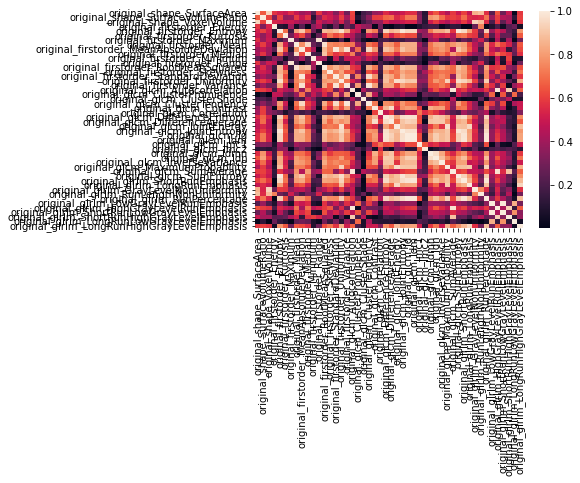

In [115]:
correlation = temp_x_train.corr()
sns.heatmap(abs(correlation), 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns)

In [185]:
reg = LinearRegression().fit(x_train, y_train)

In [184]:
prediction = reg.predict(temp_x_train)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 62 is different from 48)

In [118]:
temp_y_test = pd.DataFrame(prediction,columns=['SurvivalTime','Event'])
temp_y_test.index = x_train.index
temp_y_test

,SurvivalTime,Event
PatientID,,
202,1191.480210,0.297548
371,627.707153,0.612640
246,785.113330,0.520611
240,730.905946,0.415942
284,649.978871,0.718215
...,...,...
261,862.581565,0.394808
298,431.199234,0.802901
129,350.019436,0.448229


In [121]:
temp_y_test.index = temp_y_test.index.astype('int64')

In [122]:
temp_y_test[temp_y_test['SurvivalTime'] <= 0]

,SurvivalTime,Event
PatientID,,


In [123]:
cindex(y_train,temp_y_test)

0.6899202733483011

In [124]:
#temp_y_test.to_csv('reponse.csv', sep=',', encoding='utf-8')

<AxesSubplot:>

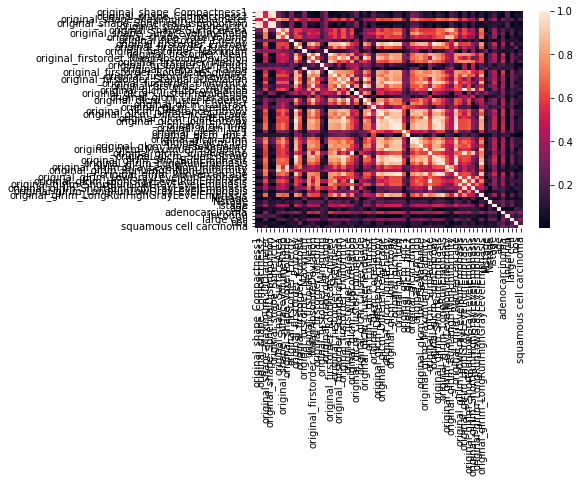

In [125]:
correlation = x_test.corr()
sns.heatmap(abs(correlation), 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns)

In [159]:
temp_y_test=x_test[temp]
temp_y_test.columns

Index(['original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_Kurtosis',
       'original_firstorder_Maximum', 'original_firstorder_Mean',
       'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range', 'original_firstorder_RootMeanSquared',
       'original_firstorder_Skewness', 'original_firstorder_StandardDeviation',
       'original_firstorder_Uniformity', 'original_firstorder_Variance',
       'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence',
       'original_glcm_ClusterShade', 'original_glcm_ClusterTendency',
       'original_glcm_Contrast', 'original_glcm_Correlation',
       'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceAverage',
       'original_glcm_JointEnergy', 'original_glcm_JointEntropy',
       'original_glcm_Id'

In [160]:
prediction = reg.predict(temp_y_test)

In [172]:
temp_y_test = pd.DataFrame(prediction,columns=['SurvivalTime','Event'])
temp_y_test.index = x_test.index
temp_y_test

,SurvivalTime,Event
PatientID,,
013,13.015125,0.665583
155,1432.820201,0.632459
404,581.283516,0.652592
407,516.460229,0.601871
009,2226.523365,-0.136623
...,...,...
066,680.692388,0.530809
132,437.086205,0.833934
169,1229.633109,0.063582


In [175]:
train_output=train_output.index.astype('int64')
temp_y_test[temp_y_test['SurvivalTime'] <= 0]

,SurvivalTime,Event
PatientID,,
179,-52.635376,0.936233
326,-345.590086,0.398838


In [181]:
temp_y_test.to_csv('y_test.csv', sep=',')

# Evaluer

In [58]:
import numpy as np
import pandas as pd
import warnings


def cindex(y_true_times, predicted_times, tol=1e-8):
    """
    Author: Romuald Menuet & Rémy Dubois

    Evaluate concordance index from Pandas DataFrame, taking ties into account.

    Args:
        y_true_times: pd.DataFrame
            pd DataFrame with three columns: `PatientID`, `Event` and `SurvivalTime` the float-valued column of true survival times.
        predicted_times: pd.DataFrame
            pd DataFrame with three columns: `PatientID`, `SurvivalTime` the float-valued column of predicted survival times,
            and one `Event`column, whose value does not matter. It must be appended so that target and predictions have the same format.
        tol: float
            small float value for numerical stability.
    Returns:
        Concordance index, as described here:
        https://square.github.io/pysurvival/metrics/c_index.html
    """

    assert isinstance(y_true_times, pd.DataFrame), 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert isinstance(predicted_times, pd.DataFrame), 'Predicted times should be pd dataframe with patient `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert len(y_true_times.shape) == 2, 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert len(predicted_times.shape) == 2, 'Predicted times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert set(y_true_times.columns) == {'Event', 'SurvivalTime'}, 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert set(predicted_times.columns) == {'Event', 'SurvivalTime'}, 'Predicted times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    np.testing.assert_equal(y_true_times.shape, predicted_times.shape, err_msg="Not same amount of predicted versus true samples")
    assert set(y_true_times.index) == set(predicted_times.index), 'Not same patients in prediction versus ground truth'
    assert np.all(predicted_times['SurvivalTime'] > 0), 'Predicted times should all be positive'

    events = y_true_times.Event
    y_true_times = y_true_times.SurvivalTime
    predicted_times = predicted_times.SurvivalTime

    # Just ordering the right way
    predicted_times = predicted_times.loc[y_true_times.index]
    events = events.loc[y_true_times.index]

    events = events.values.astype(int)
    y_true_times = y_true_times.values.astype(float)
    predicted_times = predicted_times.values.astype(float)
    # events = events.values.astype(bool)

    np.testing.assert_array_less(1.,
                                 predicted_times.astype(float),
                                 err_msg="Predicted y_true_times all below 1.\
                                 It should be in days. Make sure that you are not predicting risk instead of time.")

    return _cindex_np(y_true_times, predicted_times, events)


def _cindex_np(times, predicted_times, events, tol=1.e-8):
    """
    Raw CI computation from np arrray. Should not be used as is.
    """
    assert times.ndim == predicted_times.ndim == events.ndim == 1, "wrong input, should be vectors only"
    assert times.shape[0] == predicted_times.shape[0] == events.shape[0], "wrong input, should be vectors of the same len"

    risks = - predicted_times

    risks_i = risks.reshape((-1, 1))
    risks_j = risks.reshape((1, -1))
    times_i = times.reshape((-1, 1))
    times_j = times.reshape((1, -1))
    events_i = events.reshape((-1, 1))

    eligible_pairs = (times_i < times_j) * events_i

    well_ordered = np.sum(eligible_pairs * (risks_i > risks_j))
    ties = + np.sum(eligible_pairs * 0.5 * (risks_i == risks_j))

    return (well_ordered + ties) / (eligible_pairs.sum() + tol)
